### building a decision tree with python

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# this function displays the splits of the tree
from sklearn.tree import plot_tree

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

In [72]:
df_original = pd.read_csv('../datasets/Churn_Modelling.csv')
df_original.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [73]:
df_original['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

In [74]:
churn_df = df_original.drop(['RowNumber', 'CustomerId', 'Surname', 'Gender'], axis=1)

In [75]:
churn_df = pd.get_dummies(churn_df, drop_first=True)
churn_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True


In [76]:
y = churn_df['Exited']

X = churn_df.copy()
X = X.drop('Exited', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [77]:
decision_tree = DecisionTreeClassifier(random_state=0)

decision_tree.fit(X_train, y_train)

dt_pred = decision_tree.predict(X_test)

In [78]:
print("Accuracy:", "%.3f" % accuracy_score(y_test, dt_pred))
print("Precision:", "%.3f" % precision_score(y_test, dt_pred))
print("Recall:", "%.3f" % recall_score(y_test, dt_pred))
print("F1 Score:", "%.3f" % f1_score(y_test, dt_pred))

Accuracy: 0.790
Precision: 0.486
Recall: 0.503
F1 Score: 0.494


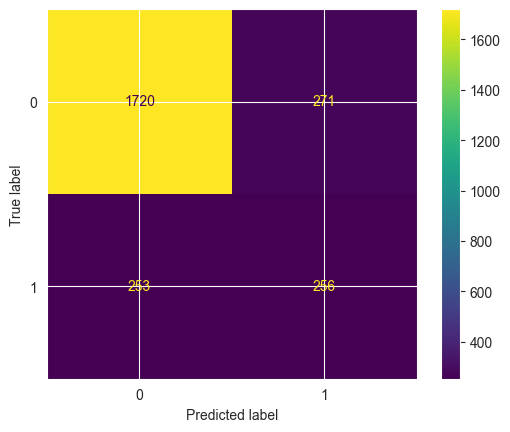

In [79]:
cm = confusion_matrix(y_test, dt_pred,labels=decision_tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=decision_tree.classes_)

disp.plot()
plt.show()

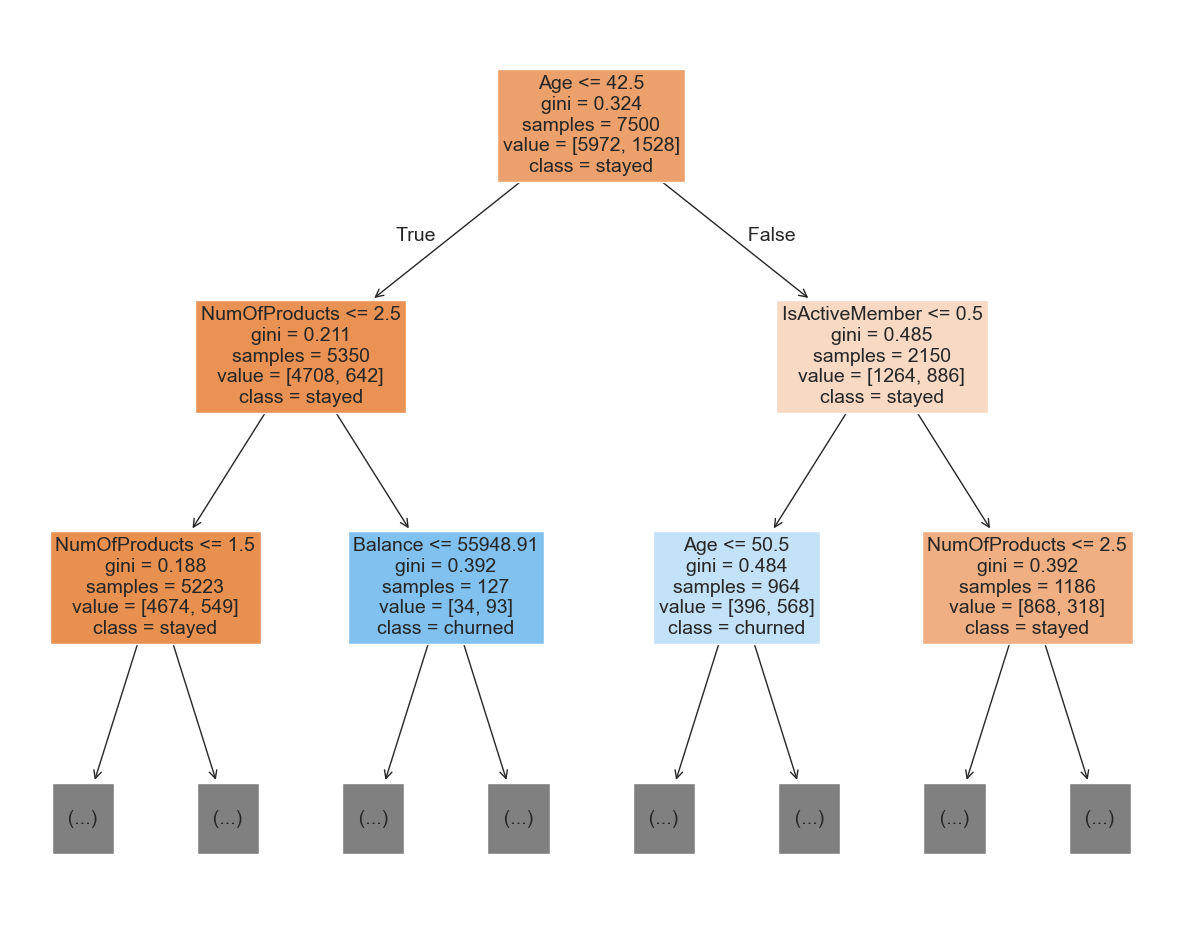

In [80]:
plt.figure(figsize=(15,12))
plot_tree(decision_tree, max_depth=2, fontsize=14, feature_names=X.columns, class_names={0:'stayed', 1:'churned'}, filled=True)
plt.show()

### tuning and validating decision tree

In [81]:
from sklearn.model_selection import GridSearchCV

In [82]:
tree_para = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50],
             'min_samples_leaf': [2, 5, 10, 20, 50]}

In [83]:
scoring=['accuracy', 'recall', 'precision', 'f1']

In [84]:
tuned_decision_tree = DecisionTreeClassifier(random_state = 42)

In [85]:
clf = GridSearchCV(tuned_decision_tree, tree_para, scoring = scoring, cv=5, refit="f1")

In [86]:
clf.fit(X_train, y_train)

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'max_depth': [4, 5, ...], 'min_samples_leaf': [2, 5, ...]}"
,scoring,"['accuracy', 'recall', ...]"
,n_jobs,None
,refit,'f1'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [87]:
clf.best_estimator_

,criterion,'gini'
,splitter,'best'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,20
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [88]:
print("Best Avg. Validation Score: ", "%.4f" % clf.best_score_)

Best Avg. Validation Score:  0.5607


In [89]:
def make_results(model_name, model_object):

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'Model': [model_name],
                        'F1': [f1],
                        'Recall': [recall],
                        'Precision': [precision],
                        'Accuracy': [accuracy]
                         }
                        )

    return table

In [90]:
result_table = make_results("Tuned Decision Tree", clf)
result_table.to_csv("Results.csv")
result_table

,Model,F1,Recall,Precision,Accuracy
0,Tuned Decision Tree,0.560655,0.469255,0.701608,0.8504
